设 $\Omega=[0,1]^2$，真解 $u=[x_1(1-x_1)x_2(1-x_2),0]$。$u$ 的选择确保了在边界 $\partial\Omega$ 上 $u=0$。

$$f = 
\begin{bmatrix}
35/13x_2-35/13x_2^2+10/13x_1-10/13x_1^2\\
-25/26(-1+2x_2)(-1+2x_1)
\end{bmatrix}$$
其中 $E=1$ 和 $\nu=0.3$。

In [100]:
p = 1
GD = 2
n = 1
doforder = 'vdims'

In [101]:
from linear_elasticity_model2d import BoxDomainData2d

pde = BoxDomainData2d()

mu = pde.mu
lambda_ = pde.lam
domain = pde.domain()
mesh = pde.init_mesh(n=n)
NC = mesh.number_of_cells()
print("NC:", NC)
NN = mesh.number_of_nodes()
print("NN:", NN)

NC: 696
NN: 371


In [102]:
import os
from fealpy.functionspace import LagrangeFESpace as Space

output = './visualization/'
if not os.path.exists(output):
    os.makedirs(output)
fname = os.path.join(output, 'DelaunayMesh.vtu')

space = Space(mesh, p=p, doforder=doforder)
uh = space.function(dim=GD)
print("uh:", uh.shape)
vspace = GD*(space, )
gdof = vspace[0].number_of_global_dofs()
vgdof = gdof * GD
print("vgdof:", vgdof)
ldof = vspace[0].number_of_local_dofs()
vldof = ldof * GD
print("vldof:", vldof)

uh: (371, 2)
vgdof: 742
vldof: 6


刚度矩阵

In [103]:
from fealpy.fem import LinearElasticityOperatorIntegrator
from fealpy.fem import BilinearForm

integrator1 = LinearElasticityOperatorIntegrator(lam=lambda_, mu=mu, q=p+1)

bform = BilinearForm(vspace)
bform.add_domain_integrator(integrator1)
KK = integrator1.assembly_cell_matrix(space=vspace)
print("KK", KK.shape)
K = bform.assembly()
print("K:", K.shape)

KK (696, 6, 6)
K: (742, 742)


In [104]:
from fealpy.fem import VectorSourceIntegrator
from fealpy.fem import LinearForm

integrator3 = VectorSourceIntegrator(f = pde.source, q=5)

lform = LinearForm(vspace)
lform.add_domain_integrator(integrator3)
FK = integrator3.assembly_cell_vector(space = vspace)
print("FK:", FK.shape)
F = lform.assembly()
print("F:", F.shape)

FK: (696, 3, 2)
F: (742,)


In [105]:
import numpy as np
from scipy.sparse import spdiags

dflag = vspace[0].boundary_interpolate(
        gD=pde.dirichlet, uh=uh,
        threshold=pde.is_dirichlet_boundary)
print("dflag:", dflag.shape)
ipoints = vspace[0].interpolation_points()
uh[dflag] = pde.dirichlet(ipoints[dflag])

F -= K@uh.flat
F[dflag.flat] = uh.ravel()[dflag.flat]
print("F:", F.shape)

bdIdx = np.zeros(K.shape[0], dtype=np.int_)
bdIdx[dflag.flat] = 1
D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
K = D0@K@D0 + D1
print("K:", K.shape)

dflag: (371, 2)
F: (742,)
K: (742, 742)


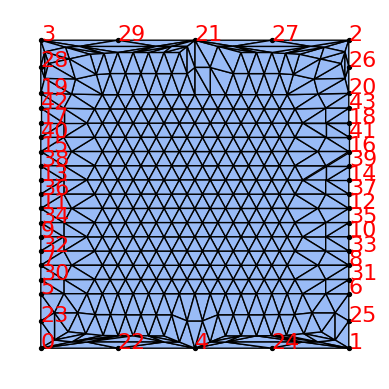

In [106]:
dflag = vspace[0].is_boundary_dof()
node = mesh.entity('node')
bd_points = node[dflag]

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, node=points, showindex=True, 
               color='k', marker='o', markersize=8, fontsize=16, fontcolor='r')
plt.show()